<a href="https://colab.research.google.com/github/GerardoMunoz/robots/blob/main/arm_direct_kinematics_row_vector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
%reset -f

# Direct Kinematics with Row-Vector Convention

This notebook demonstrates how to build the **direct kinematics transformation matrix** using the row-vector convention (as in Three.js). We will use SymPy for symbolic computation.

## Robot structure:
- Rotation about Y (θ0)
- Translation along Y (a0)
- Rotation about Z (θ1)
- Translation along X (a1)
- Rotation about Z (θ2)
- Translation along X (a2)

The final afin transform is:

\[ T = R_y(θ0) T_y(a0) R_z(θ1) T_x(a1) R_z(θ2) T_x(a2) \]

We will construct and simplify this step by step.

In [82]:
import sympy as sp

# Define symbols
θ0, θ1, θ2 = sp.symbols('θ0 θ1 θ2', real=True)
a0, a1, a2 = sp.symbols('a0 a1 a2', real=True)

# === Helper transforms in ROW-VECTOR convention ===

def R_y(theta):
    return sp.Matrix([
        [sp.cos(theta), 0, -sp.sin(theta), 0],
        [0,             1,  0,             0],
        [sp.sin(theta), 0,  sp.cos(theta), 0],
        [0,             0,  0,             1]
    ])

def R_z(theta):
    return sp.Matrix([
        [sp.cos(theta), sp.sin(theta), 0, 0],
        [-sp.sin(theta), sp.cos(theta), 0, 0],
        [0,              0,             1, 0],
        [0,              0,             0, 1]
    ])

def T_x(a):
    return sp.Matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [a, 0, 0, 1]
    ])

def T_y(a):
    return sp.Matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, a, 0, 1]
    ])


## Step 1: Build the transformation chain

Each elementary transform corresponds to a joint or a link:

In [83]:
# Build chain of transforms
T1 = R_y(θ0)
T2 = T_y(a0)
T3 = R_z(θ1)
T4 = T_x(a1)
T5 = R_z(θ2)
T6 = T_x(a2)

# Total transform (row-vector convention)
T = T1 * T2 * T3 * T4 * T5 * T6
T_simplified = sp.simplify(T)

T_simplified

Matrix([
[              cos(θ0)*cos(θ1 + θ2),         sin(θ1 + θ2)*cos(θ0), -sin(θ0), 0],
[                     -sin(θ1 + θ2),                 cos(θ1 + θ2),        0, 0],
[              sin(θ0)*cos(θ1 + θ2),         sin(θ0)*sin(θ1 + θ2),  cos(θ0), 0],
[-a0*sin(θ1 + θ2) + a1*cos(θ2) + a2, a0*cos(θ1 + θ2) + a1*sin(θ2),        0, 1]])

## Step 2: Extract end-effector position

In the row-vector convention, the **last row** of the afin matrix contains the translation \([x, y, z, 1]\).

In [84]:
# Extract end-effector position
end_effector = T_simplified[-1, 0:3]
end_effector

Matrix([[-a0*sin(θ1 + θ2) + a1*cos(θ2) + a2, a0*cos(θ1 + θ2) + a1*sin(θ2), 0]])

## Step 3: Verify with substitution

We can plug in numerical values for angles and link lengths to test the result.

In [85]:
# Example substitution: θ0=0, θ1=90°, θ2=0, a0=1, a1=1, a2=1
subs = {θ0: 0, θ1: sp.pi/2, θ2: 0, a0: 1, a1: 1, a2: 1}
numeric_position = end_effector.subs(subs).evalf()
numeric_position

Matrix([[1.0, 0, 0]])

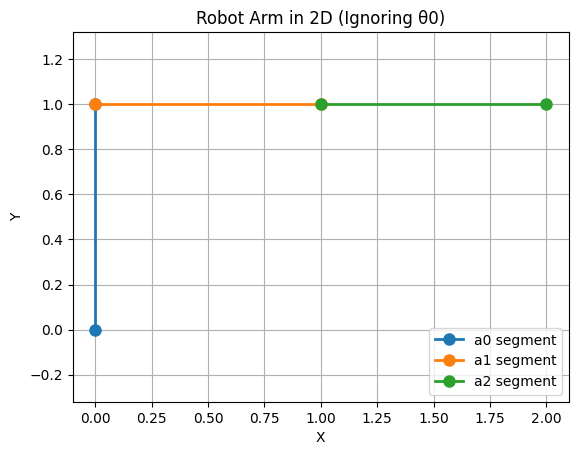

In [86]:
import matplotlib.pyplot as plt

# Define the transformation matrices for the 2D projection (ignoring θ0)
# T1 = R_y(θ0) is ignored

T2 = T_y(a0)
T3 = R_z(θ1)
T4 = T_x(a1)
T5 = R_z(θ2)
T6 = T_x(a2)

# Calculate the position of each joint by multiplying the relevant transforms
# Start with a point at the origin [0, 0, 0, 1]
origin = sp.Matrix([[0, 0, 0, 1]])

# Joint 1 (after T_y(a0)) - This is the base of the arm in the 2D projection
joint1_pos_afin = origin * T2
joint1_pos = joint1_pos_afin[0, 0:3]

# Joint 2 (after R_z(θ1) T_x(a1))
joint2_pos_afin = origin * T2 * T3 * T4
joint2_pos = joint2_pos_afin[0, 0:3]

# End-effector position (after R_z(θ2) T_x(a2)) - This is the same as T_simplified[-1, 0:3] but calculated step by step
end_effector_pos_afin = origin * T2 * T3 * T4 * T5 * T6
end_effector_pos = end_effector_pos_afin[0, 0:3]


# Substitute numerical values
subs = {θ1: 0, θ2: 0, a0: 1, a1: 1, a2: 1} # Using the same substitution as before, but excluding θ0

joint1_numeric = joint1_pos.subs(subs).evalf()
joint2_numeric = joint2_pos.subs(subs).evalf()
end_effector_numeric = end_effector_pos.subs(subs).evalf()

# Extract x and y coordinates for each joint
origin_coords = (0, 0)
joint1_coords = (joint1_numeric[0], joint1_numeric[1])
joint2_coords = (joint2_numeric[0], joint2_numeric[1])
end_effector_coords = (end_effector_numeric[0], end_effector_numeric[1])


# Plot the arm segments
plt.figure()
# Segment 1 (origin to joint1)
plt.plot([origin_coords[0], joint1_coords[0]], [origin_coords[1], joint1_coords[1]], 'o-', linewidth=2, markersize=8, label='a0 segment')
# Segment 2 (joint1 to joint2)
plt.plot([joint1_coords[0], joint2_coords[0]], [joint1_coords[1], joint1_coords[1]], 'o-', linewidth=2, markersize=8, label='a1 segment')
# Segment 3 (joint2 to end-effector)
plt.plot([joint2_coords[0], end_effector_coords[0]], [joint2_coords[1], end_effector_coords[1]], 'o-', linewidth=2, markersize=8, label='a2 segment')


plt.title('Robot Arm in 2D (Ignoring θ0)')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axis('equal') # Ensure equal scaling for x and y axes
plt.legend() # Show legend for segments
plt.show()

In [87]:
subs

{θ1: 0, θ2: 0, a0: 1, a1: 1, a2: 1}

In [88]:
joint1_pos_afin

Matrix([[0, a0, 0, 1]])

In [89]:
joint1_numeric

Matrix([[0, 1.0, 0]])

In [90]:
joint2_pos_afin

Matrix([[-a0*sin(θ1) + a1, a0*cos(θ1), 0, 1]])

In [91]:
joint2_numeric

Matrix([[1.0, 1.0, 0]])

In [92]:
end_effector_pos_afin

Matrix([[-a0*sin(θ2)*cos(θ1) + a2 + (-a0*sin(θ1) + a1)*cos(θ2), a0*cos(θ1)*cos(θ2) + (-a0*sin(θ1) + a1)*sin(θ2), 0, 1]])

In [93]:
end_effector_numeric

Matrix([[2.0, 1.0, 0]])

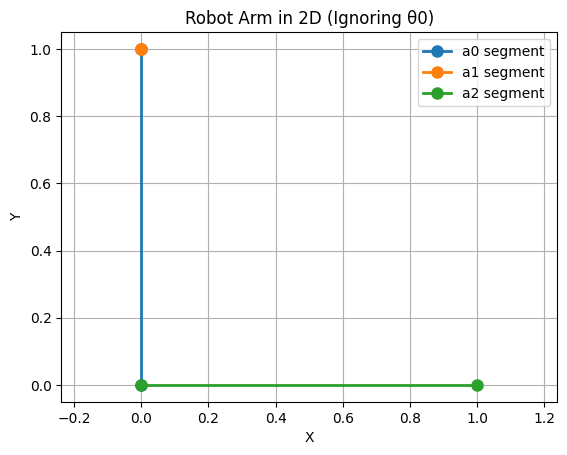

In [94]:
import matplotlib.pyplot as plt

# Define the transformation matrices for the 2D projection (ignoring θ0)
# T1 = R_y(θ0) is ignored

T2 = T_y(a0)
T3 = R_z(θ1)
T4 = T_x(a1)
T5 = R_z(θ2)
T6 = T_x(a2)

# Calculate the position of each joint by multiplying the relevant transforms
# Start with a point at the origin [0, 0, 0, 1]
origin = sp.Matrix([[0, 0, 0, 1]])

# Joint 1 (after T_y(a0)) - This is the base of the arm in the 2D projection
joint1_pos_afin = origin * T2
joint1_pos = joint1_pos_afin[0, 0:3]

# Joint 2 (after R_z(θ1) T_x(a1))
joint2_pos_afin = origin * T2 * T3 * T4
joint2_pos = joint2_pos_afin[0, 0:3]

# End-effector position (after R_z(θ2) T_x(a2)) - This is the same as T_simplified[-1, 0:3] but calculated step by step
end_effector_pos_afin = origin * T2 * T3 * T4 * T5 * T6
end_effector_pos = end_effector_pos_afin[0, 0:3]


# Substitute numerical values
subs = {θ1: sp.pi/2, θ2: 0, a0: 1, a1: 1, a2: 1} # Using the same substitution as before, but excluding θ0

joint1_numeric = joint1_pos.subs(subs).evalf()
joint2_numeric = joint2_pos.subs(subs).evalf()
end_effector_numeric = end_effector_pos.subs(subs).evalf()

# Extract x and y coordinates for each joint
origin_coords = (0, 0)
joint1_coords = (joint1_numeric[0], joint1_numeric[1])
joint2_coords = (joint2_numeric[0], joint2_numeric[1])
end_effector_coords = (end_effector_numeric[0], end_effector_numeric[1])


# Plot the arm segments
plt.figure()
# Segment 1 (origin to joint1)
plt.plot([origin_coords[0], joint1_coords[0]], [origin_coords[1], joint1_coords[1]], 'o-', linewidth=2, markersize=8, label='a0 segment')
# Segment 2 (joint1 to joint2)
plt.plot([joint1_coords[0], joint2_coords[0]], [joint1_coords[1], joint1_coords[1]], 'o-', linewidth=2, markersize=8, label='a1 segment')
# Segment 3 (joint2 to end-effector)
plt.plot([joint2_coords[0], end_effector_coords[0]], [joint2_coords[1], end_effector_coords[1]], 'o-', linewidth=2, markersize=8, label='a2 segment')


plt.title('Robot Arm in 2D (Ignoring θ0)')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axis('equal') # Ensure equal scaling for x and y axes
plt.legend() # Show legend for segments
plt.show()

In [95]:
# Install ipywidgets
%pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.9 MB/s eta 0:00:00


In [96]:
import ipywidgets as widgets
from ipywidgets import interactive

# Create sliders for θ1 and θ2
theta1_slider = widgets.FloatSlider(min=-sp.pi, max=sp.pi, step=0.01, value=0, description='θ1 (rad):')
theta2_slider = widgets.FloatSlider(min=-sp.pi, max=sp.pi, step=0.01, value=0, description='θ2 (rad):')
a0_slider = widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1, description='a0:')
a1_slider = widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1, description='a1:')
a2_slider = widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1, description='a2:')

# Display the sliders
display(theta1_slider, theta2_slider, a0_slider, a1_slider, a2_slider)

FloatSlider(value=0.0, description='θ1 (rad):', max=3.141592653589793, min=-3.141592653589793, step=0.01)

FloatSlider(value=0.0, description='θ2 (rad):', max=3.141592653589793, min=-3.141592653589793, step=0.01)

FloatSlider(value=1.0, description='a0:', max=5.0, min=0.1)

FloatSlider(value=1.0, description='a1:', max=5.0, min=0.1)

FloatSlider(value=1.0, description='a2:', max=5.0, min=0.1)

In [97]:
def plot_robot_arm(θ1, θ2, a0, a1, a2):
    # Define the transformation matrices for the 2D projection (ignoring θ0)
    T2 = T_y(a0)
    T3 = R_z(θ1)
    T4 = T_x(a1)
    T5 = R_z(θ2)
    T6 = T_x(a2)

    # Calculate the position of each joint by multiplying the relevant transforms
    # Start with a point at the origin [0, 0, 0, 1]
    origin = sp.Matrix([[0, 0, 0, 1]])

    # Joint 1 (after T_y(a0)) - This is the base of the arm in the 2D projection
    joint1_pos_afin = origin * T2
    joint1_pos = joint1_pos_afin[0, 0:3]

    # Joint 2 (after R_z(θ1) T_x(a1))
    joint2_pos_afin = origin * T2 * T3 * T4
    joint2_pos = joint2_pos_afin[0, 0:3]

    # End-effector position (after R_z(θ2) T_x(a2)) - This is the same as T_simplified[-1, 0:3] but calculated step by step
    end_effector_pos_afin = origin * T2 * T3 * T4 * T5 * T6
    end_effector_pos = end_effector_pos_afin[0, 0:3]


    # Substitute numerical values
    subs = {θ1: θ1, θ2: θ2, a0: a0, a1: a1, a2: a2}

    joint1_numeric = joint1_pos.subs(subs).evalf()
    joint2_numeric = joint2_pos.subs(subs).evalf()
    end_effector_numeric = end_effector_pos.subs(subs).evalf()

    # Extract x and y coordinates for each joint
    origin_coords = (0, 0)
    joint1_coords = (joint1_numeric[0], joint1_numeric[1])
    joint2_coords = (joint2_numeric[0], joint2_numeric[1])
    end_effector_coords = (end_effector_numeric[0], end_effector_numeric[1])


    # Plot the arm segments
    plt.figure()
    # Segment 1 (origin to joint1)
    plt.plot([origin_coords[0], joint1_coords[0]], [origin_coords[1], joint1_coords[1]], 'o-', linewidth=2, markersize=8, label='a0 segment')
    # Segment 2 (joint1 to joint2)
    plt.plot([joint1_coords[0], joint2_coords[0]], [joint1_coords[1], joint1_coords[1]], 'o-', linewidth=2, markersize=8, label='a1 segment')
    # Segment 3 (joint2 to end-effector)
    plt.plot([joint2_coords[0], end_effector_coords[0]], [joint2_coords[1], end_effector_coords[1]], 'o-', linewidth=2, markersize=8, label='a2 segment')


    plt.title('Robot Arm in 2D (Ignoring θ0)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal') # Ensure equal scaling for x and y axes
    plt.legend() # Show legend for segments
    plt.show()

# Create an interactive plot using the sliders
interactive(plot_robot_arm, θ1=theta1_slider, θ2=theta2_slider, a0=a0_slider, a1=a1_slider, a2=a2_slider)

interactive(children=(FloatSlider(value=0.0, description='θ1 (rad):', max=3.141592653589793, min=-3.1415926535…